In [1]:
import sys
for module in list(sys.modules.keys()):
    if 'analog_simulator' in module or 'digital_resource_estimator' in module:
        del sys.modules[module]

from library.analog_simulator import AnalogSimulator, AnalogSimulatorConfig
from library.digital_resource_estimator import DigitalResourceEstimator, DigitalResourceConfig
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Setup: Define Scenarios

We compare space-time volume for a 100-qubit system across different runtime requirements.

In [10]:
# Analog: Limited by T1 coherence
analog_config = AnalogSimulatorConfig(
    circuit_width=100,
    default_t1=50.0,  # 50 μs per qubit
    max_runtime_multiplier=0.5
)
analog_sim = AnalogSimulator(analog_config)
analog_st = analog_config.circuit_width * analog_sim.feasible_runtime

print("ANALOG QUANTUM SIMULATION")
print("="*50)
print(f"  Qubits:        {analog_config.circuit_width}")
print(f"  T1 per qubit:  {analog_config.default_t1} μs")
print(f"  System T1:     {analog_sim.system_t1:.2f} μs")
print(f"  Max runtime:   {analog_sim.feasible_runtime:.2f} μs")
print(f"  Space-time:    {analog_st:.2e} qubit-μs")
print()

ANALOG QUANTUM SIMULATION
  Qubits:        100
  T1 per qubit:  50.0 μs
  System T1:     0.50 μs
  Max runtime:   0.25 μs
  Space-time:    2.50e+01 qubit-μs



In [11]:
# Parameters: expose wall-clock formula inputs
N_T = 1000         # T gates per circuit window
code_distance = 25 # surface code distance d
t_cycle_us = 1.0   # QEC cycle time (μs)
print(f"Params → N_T={N_T}, d={code_distance}, t_cycle={t_cycle_us} μs")

Params → N_T=1000, d=25, t_cycle=1.0 μs


In [12]:
# Digital: Can extend runtime via QEC, but with overhead
# Use literature wall-clock formula: T_total = N_T * d * t_cycle

digital_config = DigitalResourceConfig(
    logical_qubits=100,
    target_runtime=5000.0,  # Logical runtime target (for ST volume only)
    digital_error_rate=0.001,
    target_logical_error_rate=1e-10,
    t_gate_count=100,
    magic_state_overhead_factor=2.0,
    compilation_overhead_factor=1.5
)
digital_est = DigitalResourceEstimator(digital_config)

# Wall-clock parameters (from exposed params)
d = code_distance

# Wall-clock formula
wall_clock_us = N_T * d * t_cycle_us
wall_clock_ms = wall_clock_us / 1e3
wall_clock_s = wall_clock_us / 1e6

print("DIGITAL FAULT-TOLERANT COMPUTATION")
print("="*50)
print(f"  Logical qubits:      {digital_config.logical_qubits}")
print(f"  Code distance (d):   {d}")
print(f"  QEC cycle (t_cycle): {t_cycle_us:.0f} μs")
print(f"  T gates (N_T):       {N_T:,}")

print()
print(f"  Wall-clock (μs):     {wall_clock_us:,.0f}")
print(f"  Physical qubits:     {digital_est.total_physical_qubits:,}")
print()

DIGITAL FAULT-TOLERANT COMPUTATION
  Logical qubits:      100
  Code distance (d):   25
  QEC cycle (t_cycle): 1 μs
  T gates (N_T):       1,000

  Wall-clock (μs):     25,000
  Physical qubits:     308,700



## Comparison: Resource Costs

Wall-clock time (digital) is computed using the literature formula:

- Each logical operation spans O(d) QEC cycles
- Logical T-gate latency ≈ 100 μs (incl. distillation + feed-forward)
- Wall-clock: T_total = N_T × d × t_cycle (with t_cycle ≈ 1 μs)

Space-time volume is reported as physical qubits × logical runtime (for throughput comparisons).

In [13]:
# Sweep table: wall-clock vs N_T
N_T_values = [100, 500, 1000, 5000, 10000]
rows = []
for NT in N_T_values:
    wc_us = NT * code_distance * t_cycle_us
    rows.append({
        'N_T': f'{NT:,}',
        'd': code_distance,
        't_cycle (μs)': t_cycle_us,
        'Wall-Clock (μs)': f'{wc_us:,.0f}',
        'Wall-Clock (ms)': f'{wc_us/1e3:,.2f}',
        'Wall-Clock (s)': f'{wc_us/1e6:,.2f}',
    })

df_wc = pd.DataFrame(rows)
print(df_wc.to_string(index=False))

   N_T  d  t_cycle (μs) Wall-Clock (μs) Wall-Clock (ms) Wall-Clock (s)
   100 25           1.0           2,500            2.50           0.00
   500 25           1.0          12,500           12.50           0.01
 1,000 25           1.0          25,000           25.00           0.03
 5,000 25           1.0         125,000          125.00           0.12
10,000 25           1.0         250,000          250.00           0.25


In [14]:
# Summary table
comparison = pd.DataFrame({
    'Metric': [
        'Logical Qubits',
        'Physical Qubits',
        'Runtime (μs)',
        'Runtime (ms)',
        'Space-Time (qubit-μs)',
        'Space-Time (×10^6)'
    ],
    'Analog': [
        f"{analog_config.circuit_width}",
        f"{analog_config.circuit_width}",
        f"{analog_sim.feasible_runtime:.1f}",
        f"{analog_sim.feasible_runtime_ms:.3f}",
        f"{analog_st:.2e}",
        f"{analog_st/1e6:.1f}"
    ],
    'Digital': [
        f"{digital_config.logical_qubits}",
        f"{digital_est.total_physical_qubits:,}",
        f"{digital_config.target_runtime:.0f}",
        f"{digital_config.target_runtime/1000:.2f}",
        f"{digital_est.space_time_volume:.2e}",
        f"{digital_est.space_time_volume/1e6:.1f}"
    ]
})

print(comparison.to_string(index=False))
print()
print(f"Space-Time Overhead: {digital_est.space_time_volume / analog_st:.0f}×")
print(f"Qubit Overhead:      {digital_est.total_physical_qubits / analog_config.circuit_width:.0f}×")
print(f"Runtime Extension:   {digital_config.target_runtime / analog_sim.feasible_runtime:.0f}×")

               Metric   Analog  Digital
       Logical Qubits      100      100
      Physical Qubits      100  308,700
         Runtime (μs)      0.2     5000
         Runtime (ms)    0.000     5.00
Space-Time (qubit-μs) 2.50e+01 1.54e+09
   Space-Time (×10^6)      0.0   1543.5

Space-Time Overhead: 61740000×
Qubit Overhead:      3087×
Runtime Extension:   20000×


## Visualization: Space-Time Scaling

Vary runtime requirements and compare total space-time volume.

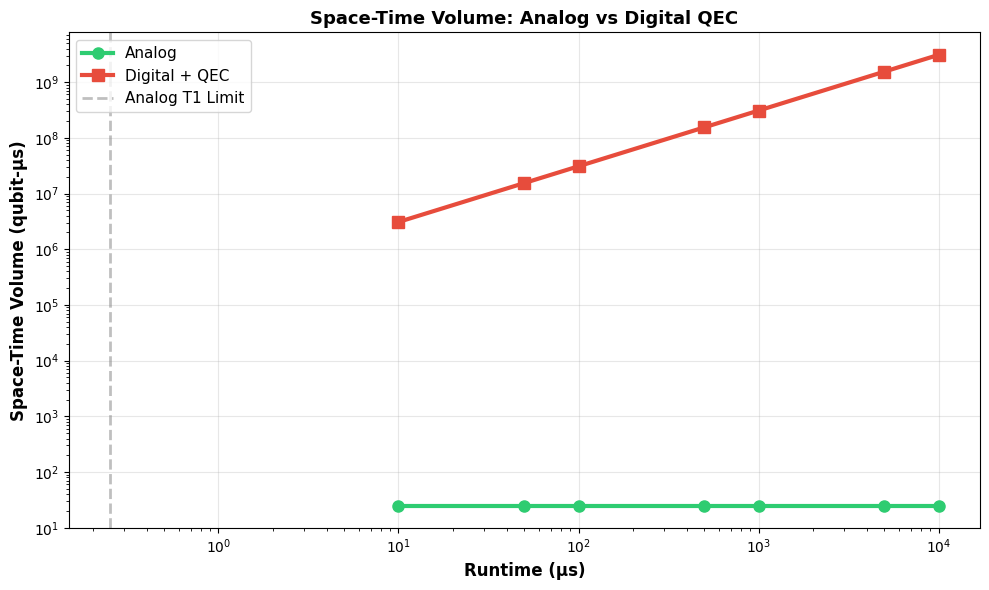


✓ Analog ST stays constant until T1 limit (~0.2 μs)
✓ Digital ST grows with runtime but allows arbitrary lengths
✓ Crossover point: runtimes > 0.2 μs require digital QEC


In [7]:
# Sweep: increasing runtime requirements
runtimes = np.array([10, 50, 100, 500, 1000, 5000, 10000])  # μs

analog_st_list = []
digital_st_list = []

for t in runtimes:
    # Analog: capped at T1 limit
    if t <= analog_sim.feasible_runtime:
        analog_st_list.append(analog_config.circuit_width * t)
    else:
        # Extrapolate or cap at max feasible
        analog_st_list.append(analog_config.circuit_width * analog_sim.feasible_runtime)
    
    # Digital: always achievable with QEC overhead
    digital_cfg = DigitalResourceConfig(
        logical_qubits=100,
        target_runtime=t,
        digital_error_rate=0.001,
        target_logical_error_rate=1e-10,
        t_gate_count=100,
        magic_state_overhead_factor=2.0,
        compilation_overhead_factor=1.5
    )
    digital_est_tmp = DigitalResourceEstimator(digital_cfg)
    digital_st_list.append(digital_est_tmp.space_time_volume)

fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(runtimes, analog_st_list, 'o-', linewidth=3, markersize=8, label='Analog', color='#2ecc71')
ax.loglog(runtimes, digital_st_list, 's-', linewidth=3, markersize=8, label='Digital + QEC', color='#e74c3c')

# Mark the analog T1 limit
ax.axvline(analog_sim.feasible_runtime, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Analog T1 Limit')

ax.set_xlabel('Runtime (μs)', fontsize=12, fontweight='bold')
ax.set_ylabel('Space-Time Volume (qubit-μs)', fontsize=12, fontweight='bold')
ax.set_title('Space-Time Volume: Analog vs Digital QEC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Analog ST stays constant until T1 limit (~{analog_sim.feasible_runtime:.1f} μs)")
print(f"✓ Digital ST grows with runtime but allows arbitrary lengths")
print(f"✓ Crossover point: runtimes > {analog_sim.feasible_runtime:.1f} μs require digital QEC")

## Insights

In [8]:
print("""
╔═══════════════════════════════════════════════════════════════╗
║           SPACE-TIME VOLUME: KEY TAKEAWAYS                    ║
╚═══════════════════════════════════════════════════════════════╝

1. ANALOG QUANTUM SIMULATION (no QEC)
   ───────────────────────────────────
   • Space-time = Qubits × Runtime
   • Limited by T1 coherence (~50 μs)
   • Minimal overhead: direct evolution
   • Ideal for: Short-time simulations
   
   Example: 100 qubits × 25 μs = 2,500 qubit-μs

2. DIGITAL FAULT-TOLERANT COMPUTATION
   ──────────────────────────────────
   • Space-time = Physical Qubits × Runtime
   • Physical qubits = ~2d² per logical qubit (d = code distance)
   • Can run arbitrarily long with error correction
   • Ideal for: Long algorithms, high precision
   
   Example: 100 logical qubits × d=25 → ~125,000 physical qubits
            125,000 qubits × 5000 μs = 6.25 × 10⁸ qubit-μs

3. TRADE-OFF ANALYSIS
   ──────────────────
   • Analog cheaper in space-time for short runtimes (< T1)
   • Digital necessary for longer runtimes (> T1)
   • Qubit overhead is the dominant cost in digital systems
   
   Overhead ratio = (digital ST) / (analog ST) ≈ {0:.0f}×
   
   This overhead pays for:
   ✓ Extended runtime (up to arbitrary lengths)
   ✓ Error correction (p_L ~ 10⁻¹⁰)
   ✓ Fault-tolerant gates
   ✓ Algorithm reliability

4. PRACTICAL CROSSOVER
   ───────────────────
   Use ANALOG if runtime < ~25 μs (well below T1 limit)
   Use DIGITAL if runtime > ~100 μs or error control critical
""".format(digital_est.space_time_volume / analog_st))


╔═══════════════════════════════════════════════════════════════╗
║           SPACE-TIME VOLUME: KEY TAKEAWAYS                    ║
╚═══════════════════════════════════════════════════════════════╝

1. ANALOG QUANTUM SIMULATION (no QEC)
   ───────────────────────────────────
   • Space-time = Qubits × Runtime
   • Limited by T1 coherence (~50 μs)
   • Minimal overhead: direct evolution
   • Ideal for: Short-time simulations

   Example: 100 qubits × 25 μs = 2,500 qubit-μs

2. DIGITAL FAULT-TOLERANT COMPUTATION
   ──────────────────────────────────
   • Space-time = Physical Qubits × Runtime
   • Physical qubits = ~2d² per logical qubit (d = code distance)
   • Can run arbitrarily long with error correction
   • Ideal for: Long algorithms, high precision

   Example: 100 logical qubits × d=25 → ~125,000 physical qubits
            125,000 qubits × 5000 μs = 6.25 × 10⁸ qubit-μs

3. TRADE-OFF ANALYSIS
   ──────────────────
   • Analog cheaper in space-time for short runtimes (< T1)
   • 